In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from davitpy import utils
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,6,8)
timeStart = datetime.datetime(2011,6,8,4,0)
selTime = datetime.datetime(2011,6,8,4,36) 
timeEnd = datetime.datetime(2011,6,8,7,0)
sapsRadList = [ "wal", "bks","fhe", "fhw", "cve","cvw" ]
sapsMlatRange = [ 56., 61. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 50 # per radar per beam
azimRngCutoff= 35.
nAzimsCutoff = 5

In [3]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
velsDF.head()

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT
0,20110608,300,1,0,-5.7955,24.2035,39.2449,-145.0924,12.5656,44.3930,143.6157,40,hok,2011-06-08 03:00:00,-11.4344
1,20110608,300,1,1,-2.5622,26.8421,39.7386,-144.9443,12.5755,44.9025,143.7975,40,hok,2011-06-08 03:00:00,-11.4245
2,20110608,300,1,2,-0.7420,26.4890,40.1807,-144.8334,12.5829,45.3574,143.9379,40,hok,2011-06-08 03:00:00,-11.4171
3,20110608,300,1,3,0.4915,3.9162,40.6033,-144.7371,12.5893,45.7913,144.0629,40,hok,2011-06-08 03:00:00,-11.4107
4,20110608,300,1,4,1.3994,3.9162,41.0157,-144.6486,12.5952,46.2139,144.1805,40,hok,2011-06-08 03:00:00,-11.4048


In [4]:
# Filter SAPS scatter using the
# following criteria!!!
# 1) select the radars where SAPS
# is observed
sapsDF = velsDF[ velsDF["radCode"].isin(sapsRadList) ]
# 2) The flows are westward!
# So beams with negative azimuth will have
# negative LoS vels and vice-versa!
sapsDF = sapsDF[sapsDF["azimCalcMag"]/sapsDF["vLos"] > 0. ]
# 3) Set a MLAT limit
sapsDF = sapsDF[ (sapsDF["MLAT"] >= sapsMlatRange[0]) &\
               (sapsDF["MLAT"] <= sapsMlatRange[1]) ]
# 4) Set a velocity cutoff
sapsDF = sapsDF[ numpy.abs(sapsDF["vLos"]) >= sapsVelCutoff ]
# 5) Limit to selected timerange
sapsDF = sapsDF[ (sapsDF["date"] >= timeStart) &\
               (sapsDF["date"] <= timeEnd) ].reset_index(drop=True)

[-3. -1. -0.]
-3.0
[-3. -1. -0.]
[-3. -1. -0.]


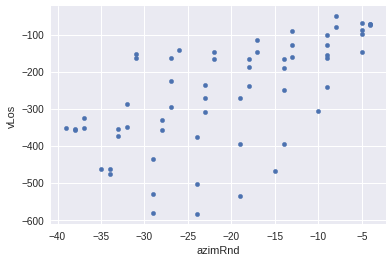

In [24]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)

# round off normMLT for L-shell fitting
sapsDF["normMLTRnd"] = sapsDF["normMLT"].round()
sapsDF["azimRnd"] = sapsDF["azimCalcMag"].round()
# We'll try to get L-shell fitted vectors at different
# (rounded) MLTs for each given time!
uniqDatesList = sorted(sapsDF["date"].unique())
for cDate in uniqDatesList:
    currLshellDF = sapsDF[ sapsDF["date"] == cDate ]
    # get all MLTs at this time and L-shell fit the data
    mltAzimDF = currLshellDF[ ["normMLTRnd", "azimRnd"]\
                    ].groupby("normMLTRnd").aggregate(\
                    lambda x: set(list(x))).reset_index()
    mltAzimDF.columns = [ "normMLTRnd", "azimList" ]
    mltDelAzimDF = currLshellDF[ ["normMLTRnd", "azimRnd"]\
                    ].groupby("normMLTRnd").aggregate(\
                    lambda x: max(x) - min(x)).reset_index()
    mltDelAzimDF.columns = [ "normMLTRnd", "delAzim" ]
    mltAzimDF = pandas.merge( mltAzimDF, mltDelAzimDF )
    if cDate == numpy.datetime64(selTime):
        # discard all MLTs where azim range is below
        # the cutoff Value
        mltAzimDF = mltAzimDF[ mltAzimDF["delAzim"] >= azimRngCutoff ]
        goodAzimList = mltAzimDF["normMLTRnd"].unique()
        for currAzim in goodAzimList:
            fitsDF = currLshellDF[ \
                             currLshellDF["normMLTRnd"] == currAzim\
                            ].reset_index(drop=True)
            print goodAzimList
            if currAzim == -3:
                print currAzim
                fitsDF.plot( x="azimRnd", y="vLos", kind="scatter", ax=ax )